In [ ]:
# ✅ STEP 1: Install Required Libraries
!pip install torch torchvision facenet-pytorch scikit-learn matplotlib pandas --quiet

# ✅ STEP 2: Import Libraries
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from facenet_pytorch import InceptionResnetV1, MTCNN
from torchvision import transforms
import random

# ✅ STEP 3: Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
mtcnn = MTCNN(image_size=160, margin=10, device=device)

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

SIMILARITY_THRESHOLD = 0.75  # Initial threshold

# ✅ STEP 4: Augmented Embedding Function with MTCNN
@torch.no_grad()
def get_augmented_embeddings(img_path, n_augments=3):
    img = Image.open(img_path).convert('RGB')
    aligned = mtcnn(img)
    if aligned is None:
        return None

    variants = [aligned.cpu()]
    for _ in range(n_augments):
        aug_img = img.copy()
        aug_img = ImageEnhance.Brightness(aug_img).enhance(np.random.uniform(0.8, 1.2))
        aug_img = ImageEnhance.Contrast(aug_img).enhance(np.random.uniform(0.8, 1.2))
        if np.random.rand() > 0.5:
            aug_img = aug_img.transpose(Image.FLIP_LEFT_RIGHT)
        aligned_aug = mtcnn(aug_img)
        if aligned_aug is not None:
            variants.append(aligned_aug.cpu())

    embeddings = []
    for v in variants:
        v = v.unsqueeze(0).to(device)
        emb = model(v).cpu().detach().numpy().flatten()
        embeddings.append(emb)

    return np.mean(embeddings, axis=0)

# ✅ STEP 5: Verification Function for Folder-Based Distortion with Optional Negatives
def verify_from_folder(folder_path, save_csv_path, use_negatives=False, negatives_per_sample=3):
    results = []
    person_list = os.listdir(folder_path)

    for person_id in tqdm(person_list, desc=f"Processing {folder_path}"):
        person_dir = os.path.join(folder_path, person_id)
        ref_img_path = os.path.join(person_dir, f"{person_id}.jpg")
        distortion_folder = os.path.join(person_dir, "distortion")

        if not os.path.exists(ref_img_path) or not os.path.isdir(distortion_folder):
            continue

        ref_embedding = get_augmented_embeddings(ref_img_path)
        if ref_embedding is None:
            continue

        for distorted_img_name in os.listdir(distortion_folder):
            distorted_img_path = os.path.join(distortion_folder, distorted_img_name)
            distorted_embedding = get_augmented_embeddings(distorted_img_path)
            if distorted_embedding is None:
                continue

            similarity = cosine_similarity([ref_embedding], [distorted_embedding])[0][0]
            results.append({
                'person_id': person_id,
                'distorted_img': distorted_img_name,
                'reference_id': person_id,
                'similarity': similarity,
                'label': 1
            })

            if use_negatives:
                other_people = [p for p in person_list if p != person_id]
                random.shuffle(other_people)
                for neg_id in other_people[:negatives_per_sample]:
                    neg_ref_path = os.path.join(folder_path, neg_id, f"{neg_id}.jpg")
                    if os.path.exists(neg_ref_path):
                        neg_embedding = get_augmented_embeddings(neg_ref_path)
                        if neg_embedding is not None:
                            sim_neg = cosine_similarity([neg_embedding], [distorted_embedding])[0][0]
                            results.append({
                                'person_id': person_id,
                                'distorted_img': distorted_img_name,
                                'reference_id': neg_id,
                                'similarity': sim_neg,
                                'label': 0
                            })

    df = pd.DataFrame(results)
    df.to_csv(save_csv_path, index=False)
    print(f"✅ Saved results to {save_csv_path}")
    return df

# ✅ STEP 6: Run for Train & Val with Negatives
train_dir = '/content/drive/MyDrive/Comys_Hackathon5/Comys_Hackathon5/Task_B/train'
val_dir = '/content/drive/MyDrive/Comys_Hackathon5/Comys_Hackathon5/Task_B/val'

df_train = verify_from_folder(train_dir, '/content/train_verification_results.csv', use_negatives=True)
df_val = verify_from_folder(val_dir, '/content/val_verification_results.csv', use_negatives=True)

# ✅ STEP 7: Threshold Tuning on Validation Set
y_true = df_val['label'].tolist()
best_thresh = 0.5
best_f1 = 0

for thresh in np.arange(0.3, 0.8, 0.01):
    preds = [1 if s >= thresh else 0 for s in df_val['similarity']]
    f1 = f1_score(y_true, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"\n🔍 Best Threshold: {best_thresh:.2f} → F1: {best_f1:.4f}")

# ✅ STEP 8: Final Evaluation with Best Threshold
y_pred = [1 if s >= best_thresh else 0 for s in df_val['similarity']]
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n📊 Evaluation on Validation Set:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.6 MB/s eta 0:00:00


  0%|          | 0.00/107M [00:00<?, ?B/s]

Processing /content/drive/MyDrive/Comys_Hackathon5/Comys_Hackathon5/Task_B/train: 100%|██████████| 877/877 [3:15:25<00:00, 13.37s/it]


✅ Saved results to /content/train_verification_results.csv


Processing /content/drive/MyDrive/Comys_Hackathon5/Comys_Hackathon5/Task_B/val: 100%|██████████| 250/250 [59:41<00:00, 14.33s/it]   


✅ Saved results to /content/val_verification_results.csv

🔍 Best Threshold: 0.40 → F1: 0.9945

📊 Evaluation on Validation Set:
Accuracy : 0.9910
Precision: 1.0000
Recall   : 0.9890
F1-Score : 0.9945


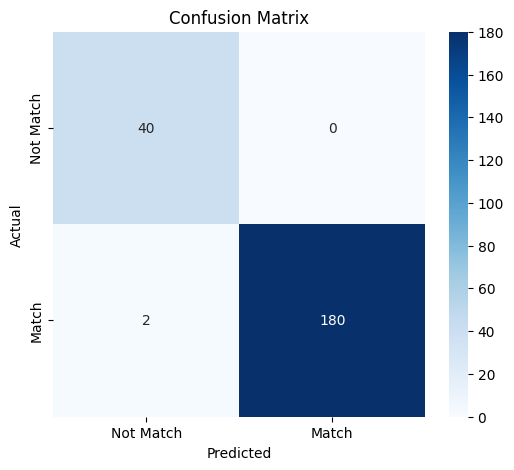

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Match', 'Match'], yticklabels=['Not Match', 'Match'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
